In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Activation, Dense, Dropout, RNN, Reshape, Embedding, concatenate
from tensorflow.keras import Model, Sequential
from keras_model import build_model_parallel

In [2]:
df = pd.read_csv('..\\data\\processed2\\processed_data2.csv', index_col=0)

In [3]:
df.sort_values(by=['date', 'gameid'], inplace=True)
df.reset_index(0, drop=True, inplace=True)

In [4]:
df['event_final'] = df['event_final'].astype('category')

In [5]:
df['event_final_code'] = df['event_final'].cat.codes

In [6]:
situation = df[['inning', 'batting team', 'outs', 'visiting_score', 'home_score', 'first', 'second', 'third']].values
batter = df['res batter'].astype('category').cat.codes.values
pitcher = df['res pitcher'].astype('category').cat.codes.values
balls = df['balls'].values
strikes = df['strikes'].values
fouls = df['fouls'].values
outcome = df['event_final_code'].values
outcome_onehot = pd.get_dummies(df['event_final_code']).values

In [7]:
situation[:, 0] -= 1

In [8]:
df.gameid.unique()

array(['BOS201004040', 'ANA201004050', 'ARI201004050', ...,
       'TEX201909290', 'TOR201909290', 'WAS201909290'], dtype=object)

In [9]:
class AtBatCell(tf.keras.layers.Layer):

    def __init__(self, n_batters, n_pitchers, situation_size, states):
        super(AtBatCell, self).__init__()
        self.n_batters = n_batters
        self.n_pitchers = n_pitchers
        self.situation_size = situation_size
        self.states = states
        self.state_size = tf.TensorShape([self.n_batters + self.n_pitchers, states])

    def build( self, input_shape ):
        self.Wz = self.add_weight('input z',
                                    shape=[self.states*2, self.situation_size])
        self.Wr = self.add_weight('input r',
                                    shape=[self.states*2, self.situation_size])
        self.Wh = self.add_weight('input h',
                                    shape=[self.states*2, self.situation_size])
        self.Uz = self.add_weight('state z',
                                    shape=[self.states*2, self.states*2],
                                    initializer=tf.keras.initializers.Identity(gain=0.8))
        self.Ur = self.add_weight('state r',
                                    shape=[self.states*2, self.states*2],
                                    initializer=tf.keras.initializers.Identity(gain=0.8))
        self.Uh = self.add_weight('state h',
                                    shape=[self.states*2, self.states*2],
                                    initializer=tf.keras.initializers.Identity(gain=0.8))
        self.bz = self.add_weight('const z',
                                    shape=[self.states*2, 1],
                                    initializer=tf.keras.initializers.Zeros)
        self.br = self.add_weight('const r',
                                    shape=[self.states*2, 1],
                                    initializer=tf.keras.initializers.Ones())
        self.bh = self.add_weight('const h',
                                    shape=[self.states*2, 1],
                                    initializer=tf.keras.initializers.Zeros)
        super(AtBatCell, self).build(input_shape)
    
    def call(self, inputs, state):
        x, b, p = inputs
        x = tf.reshape(x, (-1, 1))
        state = state[0]
        h = self.get_states(state, b, p)
        hp = self.GRU(x, h)
        state = self.update_states(state, b, p, hp, h)
        state = tf.reshape(state, (1, state.shape[0], state.shape[1]))
        return state, [state]

    def GRU(self, x, h):
        z = self.Wz @ x + self.Uz @ h + self.bz
        z = tf.math.sigmoid(z)
        r = self.Wr @ x + self.Ur @ h - self.br
        r = tf.math.sigmoid(r)
        m = self.Wh @ x + self.Uh @ (r * h) + self.bh
        m = tf.math.tanh(m)
        hp = z * h + (1-z) * m
        return hp

    def get_states(self, states, batter, pitcher):
        state_batter = tf.gather_nd(states[0], batter)
        state_pitcher = tf.gather_nd(states[0], pitcher)
        h = tf.concat((state_batter, state_pitcher), axis=0)
        return tf.reshape(h, (-1, 1))
    
    def update_states(self, states, batter, pitcher, hp, h):
        dh = hp - h
        dh = tf.reshape(dh, (2, -1))
        indices = tf.reshape([batter, pitcher], (2, 1))
        states = states[0] + tf.scatter_nd(indices, dh, states[0].shape)
        return states

class AtBatRNN(RNN):
    
    def __init__(self, n_batters, n_pitchers, situation_size, states, 
                 return_sequences=True, return_state=False,
                 stateful=True, unroll=False):
        self.n_batters = n_batters
        self.n_pitchers = n_pitchers
        self.situation_size = situation_size
        self.states = states
        cell = AtBatCell(n_batters, n_pitchers, situation_size, states)
        super(AtBatRNN, self).__init__(cell, 
            return_sequences=return_sequences, return_state=return_state,
            stateful=stateful, unroll=unroll)
        
    def call(self, inputs, initial_state=None, constants=None):
        return super(AtBatRNN, self).call(inputs, initial_state=initial_state, constants=constants)

In [10]:
class PredictionLayer(tf.keras.layers.Layer):

    def __init__(self, situation_size, states, classes):
        super(PredictionLayer, self).__init__()
        self.situation_size = situation_size
        self.states = states
        self.classes = classes

    def build( self, input_shape ):
        self.W = self.add_weight('input',
                                   shape=[self.classes, self.situation_size])
        self.U = self.add_weight('state',
                                   shape=[self.classes, self.states*2])
        self.b = self.add_weight('const',
                                   shape=[self.classes, 1])
        super(PredictionLayer, self).build(input_shape)

    def call(self, inputs):
        xp, states, bp, pp = inputs
        xp = tf.expand_dims(xp, axis=-1)
        hp = self.get_states(states, bp, pp)
        return self.W @ xp + self.U @ hp + self.b

    def get_states(self, states, batters, pitchers):
        seq_len = batters.shape[1]
        seq_len_range = tf.expand_dims(tf.range(seq_len, dtype=tf.int32), axis=1)
        batter_indices = tf.concat((seq_len_range, batters[0]),
                                   axis=1)
        pitcher_indices = tf.concat((seq_len_range, pitchers[0]),
                                    axis=1)
        state_batters = tf.gather_nd(states[0], batter_indices)
        state_pitchers = tf.gather_nd(states[0], pitcher_indices)
        h = tf.concat((state_batters, state_pitchers), axis=1)
        return tf.reshape(h, (seq_len, -1, 1))

In [11]:
def build_model( n_batters, n_pitchers, situation_size, emb, states, classes, seq_len, state_model=False ):
    
    '''
    This function builds the tensorflow model.
    '''
    b = Input(batch_shape=(1, seq_len, 1), dtype=tf.int32)
    p = Input(batch_shape=(1, seq_len, 1), dtype=tf.int32)
    sit = Input(batch_shape=(1, seq_len, situation_size))
    event = Input(batch_shape=(1, seq_len), dtype=tf.int32)
    pitch = Input(batch_shape=(1, seq_len, 3))

    ev = Embedding(classes, emb)(event)
    ev = Reshape((seq_len, emb))(ev)

    x = concatenate([sit, ev, pitch], axis=-1)

    if state_model:
        sequences = False
    else:
        sequences = True
    
    h_p = AtBatRNN(n_batters, n_pitchers, situation_size+emb+3, states, return_sequences=sequences)(tuple([x, b, p]))

    if state_model:
        return Model(inputs=[b, p, sit, event, pitch],
                     outputs=[h_p])
    
    b_p = Input(batch_shape=(1, seq_len, 1), dtype=tf.int32)
    p_p = Input(batch_shape=(1, seq_len, 1), dtype=tf.int32)
    sit_p = Input(batch_shape=(1, seq_len, situation_size))
    
    result = PredictionLayer(situation_size, states, classes)([sit_p, h_p, b_p, p_p])
    
    result = Reshape((seq_len, -1))(result)

    result = Activation('softmax')(result)

    pitch_count = PredictionLayer(situation_size, states, 3)([sit_p, h_p, b_p, p_p])
    
    model = Model(inputs=[b, p, sit, event, pitch, b_p, p_p, sit_p],
                  outputs=[result, pitch_count])
    
    return model

In [12]:
class PredictionLayerParallel(tf.keras.layers.Layer):

    def __init__(self, situation_size, states, classes):
        super(PredictionLayerParallel, self).__init__()
        self.situation_size = situation_size
        self.states = states
        self.classes = classes

    def build( self, input_shape ):
        self.W = self.add_weight('input',
                                   shape=[self.classes, self.situation_size])
        self.U = self.add_weight('state',
                                   shape=[self.classes, self.states*2])
        self.b = self.add_weight('const',
                                   shape=[self.classes, 1])
        super(PredictionLayerParallel, self).build(input_shape)

    def call(self, inputs):
        xp, states, bp, pp = inputs
        xp = tf.expand_dims(xp, axis=-1)
        hp = self.get_states(states, bp, pp)
        return self.W @ xp + self.U @ hp + self.b

    def get_states(self, states, batters, pitchers):
        seq_len = batters.shape[1]
        seq_len_range = tf.expand_dims(tf.range(seq_len, dtype=tf.int32), axis=1)
        batter_indices = tf.concat((seq_len_range, batters[0]),
                                axis=1)
        pitcher_indices = tf.concat((seq_len_range, pitchers[0]),
                                    axis=1)
        state_batters = []
        state_pitchers = []
        for state in states:
            state_batters += [tf.gather_nd(state[0], batter_indices)]
            state_pitchers += [tf.gather_nd(state[0], pitcher_indices)]
        state_batters = tf.concat(state_batters, axis=-1)
        state_pitchers = tf.concat(state_pitchers, axis=-1)
        h = tf.concat((state_batters, state_pitchers), axis=1)
        h = tf.reshape(h, (seq_len, -1, 1))
        return h

In [13]:
def build_model_parallel( n_batters, n_pitchers, situation_size, emb, states, classes, seq_len, parallel_rnns, state_model=False ):
    
    '''
    This function builds the tensorflow model.
    '''
    b = Input(batch_shape=(1, seq_len, 1), dtype=tf.int32)
    p = Input(batch_shape=(1, seq_len, 1), dtype=tf.int32)
    sit = Input(batch_shape=(1, seq_len, situation_size))
    event = Input(batch_shape=(1, seq_len), dtype=tf.int32)
    pitch = Input(batch_shape=(1, seq_len, 3))

    ev = Embedding(classes, emb)(event)
    ev = Reshape((seq_len, emb))(ev)

    x = concatenate([sit, ev, pitch], axis=-1)

    if state_model:
        sequences = False
    else:
        sequences = True
    
    h_p = []
    for i in range(parallel_rnns):
        h_p += [AtBatRNN(n_batters, n_pitchers, situation_size+emb+3, states, return_sequences=sequences)(tuple([x, b, p]))]

    if state_model:
        return Model(inputs=[b, p, sit, event, pitch],
                     outputs=h_p)

    b_p = Input(batch_shape=(1, seq_len, 1), dtype=tf.int32)
    p_p = Input(batch_shape=(1, seq_len, 1), dtype=tf.int32)
    sit_p = Input(batch_shape=(1, seq_len, situation_size))
    
    result = PredictionLayerParallel(situation_size, states*parallel_rnns, classes)([sit_p, h_p, b_p, p_p])
    
    result = Reshape((seq_len, -1))(result)

    result = Activation('softmax')(result)

    pitch_count = PredictionLayerParallel(situation_size, states*parallel_rnns, 3)([sit_p, h_p, b_p, p_p])
    
    model = Model(inputs=[b, p, sit, event, pitch, b_p, p_p, sit_p],
                  outputs=[result, pitch_count])
    
    return model

In [14]:
train = range(2*840000)
test = range(2*839995, len(df))

In [15]:
train

range(0, 1680000)

In [16]:
seq_len = 8000

In [17]:
seq_start = [len(train)%seq_len + seq_len*i for i in range(len(train)//seq_len)]
time_series = [range(start, start+seq_len) for start in seq_start]
time_series_plus = [range(start+1, start+1+seq_len) for start in seq_start]
seq_start_test = [test[0] + seq_len*i for i in range(len(test)//seq_len)]
time_series_test = [range(start, start+seq_len) for start in seq_start_test]
time_series_plus_test = [range(start+1, start+1+seq_len) for start in seq_start_test]
# time_series_test = [range(len(test))]
# time_series_plus_test = [range(1,len(test)+1)]

In [18]:
def convert_to_time_series(tensor, time_series_list):
    tensor_list = []
    for r in time_series_list:
        tensor_list += [tensor[r]]
    return np.stack(tensor_list)

In [19]:
batter_ex = np.expand_dims(batter, axis=1).astype(np.int32)
pitcher_ex = np.expand_dims(pitcher + np.unique(batter).shape[0], axis=1).astype(np.int32)

In [20]:
situation_batched = convert_to_time_series(situation, time_series)
batters_batched = convert_to_time_series(batter_ex, time_series)
pitchers_batched = convert_to_time_series(pitcher_ex, time_series)
situation_batched_plus = convert_to_time_series(situation, time_series_plus)
batters_batched_plus = convert_to_time_series(batter_ex, time_series_plus)
pitchers_batched_plus = convert_to_time_series(pitcher_ex, time_series_plus)

In [21]:
pitch_count = np.concatenate(
    (np.expand_dims(balls, axis=1), np.expand_dims(strikes, axis=1), np.expand_dims(fouls, axis=1)), axis=1
)

In [22]:
pitch_count_batched = convert_to_time_series(pitch_count, time_series)
outcome_batched = convert_to_time_series(outcome, time_series)
pitch_count_batched_plus = convert_to_time_series(pitch_count, time_series_plus)
outcome_onehot_batched_plus = convert_to_time_series(outcome_onehot, time_series_plus)

In [23]:
situation_batched_test = convert_to_time_series(situation, time_series_test)
batters_batched_test = convert_to_time_series(batter_ex, time_series_test)
pitchers_batched_test = convert_to_time_series(pitcher_ex, time_series_test)
situation_batched_plus_test = convert_to_time_series(situation, time_series_plus_test)
batters_batched_plus_test = convert_to_time_series(batter_ex, time_series_plus_test)
pitchers_batched_plus_test = convert_to_time_series(pitcher_ex, time_series_plus_test)

In [24]:
pitch_count_batched_test = convert_to_time_series(pitch_count, time_series_test)
outcome_batched_test = convert_to_time_series(outcome, time_series_test)
pitch_count_batched_plus_test = convert_to_time_series(pitch_count, time_series_plus_test)
outcome_onehot_batched_plus_test = convert_to_time_series(outcome_onehot, time_series_plus_test)

In [25]:
n_batters = np.unique(batter).shape[0]
n_pitchers = np.unique(pitcher).shape[0]
situation_size = situation.shape[1]
states = 10
embedding_dim = 12
parallel_rnns = 2
classes = outcome_onehot.shape[1]

In [144]:
model = build_model( n_batters, n_pitchers, situation_size, embedding_dim, states, classes, seq_len )

In [26]:
model = build_model_parallel( n_batters, n_pitchers, situation_size, embedding_dim, states, classes, seq_len, parallel_rnns )

In [27]:
def compile_model(model, LR):
    adam = tf.keras.optimizers.Adam(lr=LR)
    sgd = tf.keras.optimizers.SGD(lr=LR)
    model.compile(
        optimizer=sgd,
        loss=['categorical_crossentropy', 'mean_squared_error'],
        metrics=['accuracy'])
    return model

In [35]:
model.load_weights('..\\models\\prediction_model_v2_69')

In [36]:
model = compile_model(model, 1e-3)

In [37]:
model_name = '..\\models\\prediction_model_v2'
for i in range(200):
    print('epoch: '+str(i+1))
    model.reset_states()
    model.fit(x=[batters_batched, pitchers_batched, situation_batched, outcome_batched, pitch_count_batched,
                 batters_batched_plus, pitchers_batched_plus, situation_batched_plus],
              y=[outcome_onehot_batched_plus, pitch_count_batched_plus], 
              batch_size=1,
              epochs=1,
              verbose=1)
    model.save_weights(model_name + '_' + str(i+1))

epoch: 1
168/168 [==============================] - 5671s 34s/step - loss: 4.0803 - activation_loss: 3.3351 - prediction_layer_1_loss: 0.7452 - activation_accuracy: 0.1592 - prediction_layer_1_accuracy: 0.4682
epoch: 2
168/168 [==============================] - 5729s 34s/step - loss: 4.0788 - activation_loss: 3.3338 - prediction_layer_1_loss: 0.7450 - activation_accuracy: 0.1595 - prediction_layer_1_accuracy: 0.4682
epoch: 3
168/168 [==============================] - 5882s 35s/step - loss: 4.0781 - activation_loss: 3.3331 - prediction_layer_1_loss: 0.7450 - activation_accuracy: 0.1594 - prediction_layer_1_accuracy: 0.4682
epoch: 4
168/168 [==============================] - 5612s 33s/step - loss: 4.0777 - activation_loss: 3.3327 - prediction_layer_1_loss: 0.7450 - activation_accuracy: 0.1596 - prediction_layer_1_accuracy: 0.4682
epoch: 5
 14/168 [=>............................] - ETA: 1:25:43 - loss: 4.1149 - activation_loss: 3.3630 - prediction_layer_1_loss: 0.7520 - activation_accurac

ResourceExhaustedError:  OOM when allocating tensor with shape[1,10000,4939,12] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[node gradient_tape/model/prediction_layer/strided_slice_2/StridedSliceGrad (defined at <ipython-input-37-d1eed5f6a961>:10) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_train_function_3715]

Function call stack:
train_function


In [38]:
model.save_weights('..\\models\\prediction_model_v2')

In [39]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(1, 10000)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (1, 10000, 6)        678         input_4[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            [(1, 10000, 8)]      0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (1, 10000, 6)        0           embedding[0][0]                  
______________________________________________________________________________________________

In [45]:
state_model = build_model_parallel( n_batters, n_pitchers, situation_size, embedding_dim, states, classes, seq_len, parallel_rnns, True )
state_model2 = build_model_parallel( n_batters, n_pitchers, situation_size, embedding_dim, states, classes, seq_len, parallel_rnns)
state_model.load_weights('..\\models\\prediction_model_v4_51')
state_model2.load_weights('..\\models\\prediction_model_v4_51')


Two checkpoint references resolved to different objects (<__main__.AtBatRNN object at 0x000002D464E423C8> and <__main__.AtBatRNN object at 0x000002D463CBF688>).


In [26]:
state_model = build_model( n_batters, n_pitchers, situation_size, embedding_dim, states, classes, seq_len, True )
state_model.load_weights('..\\models\\prediction_model_v2_4')

In [46]:
batters_batched.shape

(210, 8000, 1)

In [47]:
state_old = state_model.layers[8].states[0].numpy()
for step in range(160, 210):
    start = step
    stop = start + 1
    print(start)
    print(stop)
    print(state_model.layers[-2].states[0].numpy()[0,3])
    #state_model.layers[8].reset_states(states=state_old)
    #print(state_model.layers[8].states[0].numpy()[0,3])
    state = state_model.predict([batters_batched[start:stop], pitchers_batched[start:stop], situation_batched[start:stop], outcome_batched[start:stop], pitch_count_batched[start:stop]])
    print(state_model.layers[-2].states[0].numpy()[0,3])
    print(state[0][0, 3])
    state_old = state

160
161
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[-0.996306   -0.02258144 -0.99999934 -0.76673555  0.00505257  0.1332661
  0.7818012   0.6566525   0.21312894 -0.35587108]
[-0.996306   -0.02258144 -0.99999934 -0.76673555  0.00505257  0.1332661
  0.7818012   0.6566525   0.21312894 -0.35587108]
161
162
[-0.996306   -0.02258144 -0.99999934 -0.76673555  0.00505257  0.1332661
  0.7818012   0.6566525   0.21312894 -0.35587108]
[-0.99747384 -0.01454293 -0.99996287 -0.88742435  0.00499301 -0.0544954
  0.7845624   0.8140287   0.15185441 -0.36102653]
[-0.99747384 -0.01454293 -0.99996287 -0.88742435  0.00499301 -0.0544954
  0.7845624   0.8140287   0.15185441 -0.36102653]
162
163
[-0.99747384 -0.01454293 -0.99996287 -0.88742435  0.00499301 -0.0544954
  0.7845624   0.8140287   0.15185441 -0.36102653]
[-0.99488485 -0.00267913 -0.9999994  -0.9247679  -0.0182273  -0.2552957
  0.8046247   0.78349936  0.2875257  -0.3591353 ]
[-0.99488485 -0.00267913 -0.9999994  -0.9247679  -0.0182273  -0.2552957
  0.8046247   0.78

In [48]:
state_final = state_model.layers[-2].states[0][0].numpy()
state_final2 = state_model.layers[-1].states[0][0].numpy()

In [39]:
state_model.layers

In [30]:
state = np.load('..\\models\\prediction_model_v2_state_3.npy')

In [50]:
np.save('..\\models\\prediction_model_v4_state2', state_final2)

In [155]:
state0 = np.load('..\\models\\prediction_model_v2_state.npy')

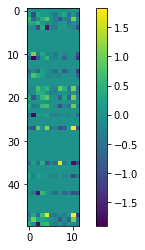

In [160]:
plt.imshow((state_final - state0)[3000:3050])
plt.colorbar()

In [ ]:
model_test = build_model( n_batters, n_pitchers, situation_size, embedding_dim, states, classes, seq_len )
model_test.load_weights('..\\models\\prediction_model_v1')

In [ ]:
model_test.layers[9].reset_states(states=np.expand_dims(state_final, axis=0))

In [ ]:
outcome_preds = []
pitch_count_preds = []
for batch in range(batters_batched_test.shape[0]):
    print(batch)
    outcome_pred, pitch_count_pred = model_test([batters_batched_test.astype(np.int32)[batch:batch+1], pitchers_batched_test.astype(np.int32)[batch:batch+1], situation_batched_test.astype(np.float32)[batch:batch+1], outcome_batched_test.astype(np.int32)[batch:batch+1], pitch_count_batched_test.astype(np.float32)[batch:batch+1], batters_batched_plus_test.astype(np.int32)[batch:batch+1], pitchers_batched_plus_test.astype(np.int32)[batch:batch+1], situation_batched_plus_test.astype(np.float32)[batch:batch+1]])
    outcome_preds += [outcome_pred.numpy()]
    pitch_count_preds += [pitch_count_pred.numpy()]
outcome_preds = np.stack(outcome_preds)
pitch_count_preds = np.stack(pitch_count_preds)

In [ ]:
outcomes_pred = np.reshape(outcome_preds, (-1, outcome_preds.shape[-1]))
pitch_count_pred = np.reshape(pitch_count_preds, (-1, 3))

In [ ]:
np.save('..\\data\\processed2\\model_v1_preds\\outcomes', outcomes_pred)
np.save('..\\data\\processed2\\model_v1_preds\\pitch_counts', pitch_count_pred)

In [ ]:
for layer in model_test.layers:
    for weight in layer.trainable_weights:
        print(weight.name)
        plt.imshow(weight.numpy())
        plt.colorbar()
        plt.show()

In [ ]:
def get_sit_feed(X, outcome_dict):
    sit_feed = {'inning' : int(round(X[0]) + 1),
                'half inning' : int(round(X[1])),
                'outs' : int(round(X[2])),
                'visiting score' : int(round(X[3])),
                'home score' : int(round(X[4])),
                'first' : int(round(X[5])),
                'second' : int(round(X[6])),
                'third' : int(round(X[7]))}
    return sit_feed

def get_sit_out_test(y_test, ind):
    test = [t[ind] for t in y_test]
    sit_out = {'inning' : np.where(test[0])[0][0]+1,
                'half inning' : int(round(test[1])),
                'outs' : np.where(test[2])[0][0],
                'visiting score' : np.where(test[3])[0][0],
                'home score' : np.where(test[4])[0][0],
                'first' : int(round(test[5])),
                'second' : int(round(test[6])),
                'third' : int(round(test[7]))}
    return sit_out

In [ ]:
cats = df['event_final'].astype('category')
bats = df['res batter'].astype('category')
pits = df['res pitcher'].astype('category')

outcome_dict = {}
for i, cat in enumerate(cats.cat.categories):
    outcome_dict[cat] = i
outcome_dict_rev = dict(enumerate(cats.cat.categories))
N_outcomes = len(outcome_dict)

bat_dict = {}
for i, bat in enumerate(bats.cat.categories):
    bat_dict[cat] = i
bat_dict_rev = dict(enumerate(bats.cat.categories))

pit_dict = {}
for i, pit in enumerate(pits.cat.categories):
    pit_dict[cat] = i
pit_dict_rev = dict(enumerate(pits.cat.categories))

In [ ]:
ev_order=df['event_final'].value_counts().index
order = []
for ev in ev_order:
    order += [outcome_dict[ev]]

In [ ]:
ind = 40020

In [ ]:
ind += 1

In [ ]:
sit_feed = get_sit_feed(situation_batched_test[ind // seq_len, ind % seq_len], outcome_dict_rev)

In [ ]:
print(sit_feed)
print(bat_dict_rev[batters_batched_test[ind // seq_len, ind % seq_len][0]])
print(pit_dict_rev[pitchers_batched_test[ind // seq_len, ind % seq_len][0]-np.unique(batter).shape[0]])

In [ ]:
plt.rcParams['figure.figsize'] = 16,8
plt.bar(np.arange(20), outcomes_pred[ind][np.array(order)[:20]])
plt.xticks(np.arange(20), ev_order[:20])
plt.title('Probability of event')
plt.ylim([0, 0.3])
plt.show()